# RagFeed

RagFeed is a feed reader powered by RAG and LLM models.

The main feature is to provide an overview of the most relevant topics on the articles from the RSS sources provided by the user and allow him/her to ask questions to its feed to dive into the topics. 

Other posible features (future) is to allow the user to rate specific articles in grade of interest so the app could filter the most relevant topics based on preferences and create a custom feed, similar to the one provided by social networks but based on the user provided RSS sources.

## Setup

In [217]:
# This notebook can be run with the environment created for RagFeed (../requirements.txt) but requires some extra libraries
!pip install matplotlib seaborn

In [284]:

import requests
from bs4 import BeautifulSoup
from datetime import datetime
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

In [219]:
# Custom functions
%load_ext autoreload
%autoreload 2
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [220]:
source = False

## Data Collection & Preparation

The data for this application needs to be partially provided by the user (selected sources) and partially obtained through internet.

For the example I selected some sources provided in this [article](https://blog.tipp.so/best-rss-feeds-2025-guide/).

### Getting the articles

The way to access the data then is by periodically do a request to each source to download the latest articles in XML format:

In [221]:
# Example of getting the RSS
if not source:
    response = requests.get("https://rss.nytimes.com/services/xml/rss/nyt/World.xml")
    if response.status_code == 200:
        source=response.content

print(source)

b'<?xml version="1.0" encoding="UTF-8"?>\n<rss xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:media="http://search.yahoo.com/mrss/" xmlns:atom="http://www.w3.org/2005/Atom" xmlns:nyt="http://www.nytimes.com/namespaces/rss/2.0" version="2.0">\n  <channel>\n    <title>NYT &gt; World News</title>\n    <link>https://www.nytimes.com/section/world</link>\n    <atom:link href="https://rss.nytimes.com/services/xml/rss/nyt/World.xml" rel="self" type="application/rss+xml"></atom:link>\n    <description></description>\n    <language>en-us</language>\n    <copyright>Copyright 2025 The New York Times Company</copyright>\n    <lastBuildDate>Wed, 02 Jul 2025 13:49:42 +0000</lastBuildDate>\n    <pubDate>Wed, 02 Jul 2025 13:38:23 +0000</pubDate>\n    <image>\n      <title>NYT &gt; World News</title>\n      <url>https://static01.nyt.com/images/misc/NYT_logo_rss_250x40.png</url>\n      <link>https://www.nytimes.com/section/world</link>\n    </image>\n    <item>\n      <title>Israelis Set a Palestinian

### Data Processing

Since XML is an structured format similar to HTML I used BeautidulSoap to get the information organized.

In [222]:
soup = BeautifulSoup(source, 'xml')

def cleanCategories(categories):
    result = []
    for category in categories:
        result += category.text.split(" / ")
    return set(result)

articles = []  
for item in soup.find_all('item'):
    article = {}
    article["title"] = item.title.text
    article["description"] = item.description.text
    article["link"] = item.link.text
    article["creator"] = item.find('dc:creator').text if item.find('dc:creator') else False
    if item.pubDate:
        try:
            if item.pubDate.text[27] in ["+", "-"]:
                # TimeZone Defined as UTC Offset
                article["pub_date"] = datetime.strptime(item.pubDate.text,'%a, %d %b %Y %H:%M:%S %z')
            else:
                # TimeZone Defined by Zone Name
                article["pub_date"] = datetime.strptime(item.pubDate.text,'%a, %d %b %Y %H:%M:%S %Z')
        except:
            # In case any of both formats for timezone works
            article["pub_date"] = datetime.strptime(item.pubDate.text[:24],'%a, %d %b %Y %H:%M:%S')
    else:
        article["pub_date"] = datetime.now()  
    article["categories"] = cleanCategories(item.find_all('category')) if item.category else []
    article["media_url"] = item.find('media:content').attrs["url"] if item.find('media:content', url=True) else False
    article["media_medium"] = item.find('media:content').attrs["medium"] if item.find('media:content', medium=True) else False
    article["media_height"] = item.find('media:content').attrs["media_height"] if item.find('media:content', media_height=True) else False
    article["media_credit"] = item.find('media:credit').text if item.find('media:credit') else False
    article["media_description"] = item.find('media:description').text if item.find('media:description') else False

    articles.append(article)

source_articles_df = pd.DataFrame(articles)
display(source_articles_df.head(10))

,title,description,link,creator,pub_date,categories,media_url,media_medium,media_height,media_credit,media_description
0,Israelis Set a Palestinian Village Ablaze in W...,"The violence last week in Kafr Malik, in the W...",https://www.nytimes.com/2025/07/01/world/middl...,Fatima AbdulKarim and Daniel Berehulak,2025-07-01 17:56:03,"{Civilian Casualties, Israeli Settlements, Wes...",https://static01.nyt.com/images/2025/07/01/mul...,image,False,False,The family of Murshid Hamayel at his wake on F...
1,What to Know About the Heat Wave in Europe,Weather agencies have issued alerts warning of...,https://www.nytimes.com/2025/06/30/world/europ...,"Lynsey Chutel, Nazaneen Ghaffar and Amelia Nie...",2025-07-02 11:21:01,"{Heatstroke, Europe, Great Britain, Portugal, ...",https://static01.nyt.com/images/2025/07/30/mul...,image,False,Christophe Archambault/Agence France-Presse — ...,"A worker in Bordeaux, France, on Tuesday."
2,Pause in U.S. Weapons Deepens Ukrainian Concer...,The suspension includes air defense intercepto...,https://www.nytimes.com/2025/07/02/world/europ...,Constant Méheut,2025-07-02 12:38:04,"{Foreign Aid, Defense and Military Forces, Ukr...",https://static01.nyt.com/images/2025/07/02/mul...,image,False,Tyler Hicks/The New York Times,A Soviet-era antiaircraft cannon operated by U...
3,Israeli Officials Express Optimism on Gaza Cea...,It is unclear whether the latest U.S.-backed e...,https://www.nytimes.com/2025/07/02/world/middl...,Aaron Boxerman and Ronen Bergman,2025-07-02 11:11:02,"{Gaza Strip, Israel-Gaza War (2023- ), Israel,...",https://static01.nyt.com/images/2025/07/02/mul...,image,False,Saher Alghorra for The New York Times,Damage from Israeli strikes in central Gaza Ci...
4,Rachel Reeves in Tears in UK Parliament As Que...,"Rachel Reeves, Britain’s most senior finance o...",https://www.nytimes.com/2025/07/02/world/europ...,Stephen Castle and Eshe Nelson,2025-07-02 13:28:05,"{Great Britain, Politics and Government, Reeve...",https://static01.nyt.com/images/2025/07/02/wor...,image,False,"UK Parliament, via Associated Press",A screenshot from the British Parliament showe...
5,Dalai Lama Tightens Grip on Reins of Successio...,The aging Tibetan spiritual leader is looking ...,https://www.nytimes.com/2025/07/02/world/asia/...,Mujib Mashal and Hari Kumar,2025-07-02 10:43:03,"{Tibet, Buddhism, China, Himalayas, Politics a...",https://static01.nyt.com/images/2025/07/02/mul...,image,False,Atul Loke for The New York Times,Tibetan Buddhist monks gathered in Dharamshala...
6,Kim Jong-un Appears to Mourn His Troops Killed...,Through an event shown on North Korean state t...,https://www.nytimes.com/2025/07/02/world/asia/...,Choe Sang-Hun,2025-07-02 09:32:05,"{Putin, Vladimir V, Deaths (Fatalities), Polit...",https://static01.nyt.com/images/2025/07/02/mul...,image,False,"Korean Central News Agency, via Reuters",A still image taken from a video showing North...
7,Dalai Lama Succession: How the Next Tibetan Sp...,The Tibetan spiritual leader said that his lin...,https://www.nytimes.com/2025/07/02/world/asia/...,Mujib Mashal and Hari Kumar,2025-07-02 12:40:00,"{Tibet, Buddhism, Dharamsala (India), Communis...",https://static01.nyt.com/images/2025/07/01/mul...,image,False,Atul Loke for The New York Times,The Dalai Lama has hinted that he might buck e...
8,Prime Minister Paetongtarn Shinawatra Suspende...,Paetongtarn Shinawatra is accused of ethical l...,https://www.nytimes.com/2025/07/01/world/asia/...,Sui-Lee Wee,2025-07-01 19:46:04,"{Ethics and Official Misconduct, Hun Sen, Poli...",https://static01.nyt.com/images/2025/07/01/mul...,image,False,Athit Perawongmetha/Reuters,Prime Minister Paetongtarn Shinawatra of Thail...
9,The First Income Tax in the Persian Gulf Signa...,A plan by Oman is being closely watched by oth...,https://www.nytimes.com/2025/07/02/world/middl...,Turki Al-Balushi and Vivian Nereim,2025-07-02 11:09:03,"{Middle East, Saudi Arabia, Income Tax, Persia...",https://static01.nyt.com/images/2025/07/02/mul...,image

In the same import process the data is cleaned:
- Structure the data
- Check if tag is set or set a False value instead (this value is used later in the program execution)
- Transform date into a python datetime format based on the source format or set the read date as alternative in order to ensure all articles has a date.
- Categories are cleaned, sub-categories are split and everything is grouped in a set to ensure there are no duplications.
- Media labels are the less standarized ones so some conditional decision is taken to ensure to keep as much information as possible.


More cleaning is required since different sources implemented the XML in different.

### Data Storage

Given sources provide a limited amount of articles I store the formated data in a SQLite database.

A copy of the used database is provided so the results of this analysis are reproducible.

In [290]:
import sqlite3
import pandas as pd
# Create your connection.
con = sqlite3.connect('./data/ragfeed_analysis.db')
database_articles_df = pd.read_sql_query("SELECT * FROM articles ORDER BY pub_date DESC", con)
database_sources_df = pd.read_sql_query("SELECT * FROM sources", con)
database_articles_df.head(5)

,id,id_source,title,description,link,creator,pub_date,categories,media_url,media_medium,media_height,media_credit,media_description,in_vectorstore
0,566,4,What is going wrong for Hamilton and Ferrari?,"Lewis Hamilton at Ferrari has ""so far not live...",https://www.bbc.com/sport/formula1/articles/c4...,NULL,1751432526,NULL,NULL,NULL,NULL,NULL,NULL,1
1,507,4,Heathrow shutdown caused by problem found seve...,A report found that moisture affected parts at...,https://www.bbc.com/news/articles/cly22eelnxjo,NULL,1751431588,NULL,NULL,NULL,NULL,NULL,NULL,1
2,485,1,Dalai Lama Tightens Grip on Reins of Successio...,The aging Tibetan spiritual leader is looking ...,https://www.nytimes.com/2025/07/02/world/asia/...,Mujib Mashal and Hari Kumar,1751431264,"Communist Party of China, Tibet, Himalayas, Re...",https://static01.nyt.com/images/2025/07/02/mul...,image,NULL,Atul Loke for The New York Times,Tibetan Buddhist monks gathered in Dharamshala...,1
3,506,4,Trump says Israel has agreed to conditions for...,"US president warns Hamas ""it will only get wor...",https://www.bbc.com/news/articles/cgkg4m0133po,NULL,1751429271,NULL,NULL,NULL,NULL,NULL,NULL,1
4,505,4,Slow-motion humiliation for Starmer as he lose...,The BBC's political editor Chris Mason and chi...,https://www.bbc.com/news/articles/czry6gv80mjo,NULL,1751428350,NULL,NULL,NULL,NULL,NULL,NULL,1


## Exploratory Data Analysis

### Initial Analysis

In [224]:
## Review Shape
print("Shape:", database_articles_df.shape)

## Get data information
database_articles_df.info()
database_articles_df.describe()

## Check data types
print("\nReview dtypes:")
display(database_articles_df.dtypes)

## Look for NA Values
print("NA Values")
display(database_articles_df.isna().sum())

## Look for duplicates
print("Duplicates", database_articles_df.duplicated().sum())

Shape: (566, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 566 non-null    int64 
 1   id_source          566 non-null    int64 
 2   title              566 non-null    object
 3   description        566 non-null    object
 4   link               566 non-null    object
 5   creator            566 non-null    object
 6   pub_date           566 non-null    int64 
 7   categories         566 non-null    object
 8   media_url          566 non-null    object
 9   media_medium       566 non-null    object
 10  media_height       566 non-null    object
 11  media_credit       566 non-null    object
 12  media_description  566 non-null    object
 13  in_vectorstore     566 non-null    int64 
dtypes: int64(4), object(10)
memory usage: 62.0+ KB

Review dtypes:


id                    int64
id_source             int64
title                object
description          object
link                 object
creator              object
pub_date              int64
categories           object
media_url            object
media_medium         object
media_height         object
media_credit         object
media_description    object
in_vectorstore        int64
dtype: object

NA Values


id                   0
id_source            0
title                0
description          0
link                 0
creator              0
pub_date             0
categories           0
media_url            0
media_medium         0
media_height         0
media_credit         0
media_description    0
in_vectorstore       0
dtype: int64

Duplicates 0


**Analysis:**
- There are 566 articles with 14 features
- There are 2 id fields that indicated the source id and the article id in the database
- There are no NA Values but there are a lot of NULL values not being converted
- There are neither duplicated values (this is expected since database use link as unique)
- There are some datatypes that should be fixed

### Analyisis Data Cleaning

In [225]:
# Transform Date
clean_articles_df = database_articles_df.copy()
clean_articles_df["pub_date"] = pd.to_datetime(clean_articles_df["pub_date"], unit='s')

# ID's should be integer
clean_articles_df["id"] = clean_articles_df["id"].astype("int64")
clean_articles_df["id_source"] = clean_articles_df["id_source"].astype("int64")

# Transform media_height intro a numeric
clean_articles_df.loc[clean_articles_df["media_height"] == "NULL", "media_height"] = "0"
clean_articles_df["media_height"] = clean_articles_df["media_height"].astype("int64")

# Replace NULL with NA
for column in clean_articles_df.columns:
    clean_articles_df.loc[clean_articles_df[column] == "NULL", column] = pd.NA

clean_articles_df

,id,id_source,title,description,link,creator,pub_date,categories,media_url,media_medium,media_height,media_credit,media_description,in_vectorstore
0,566.0,4.0,What is going wrong for Hamilton and Ferrari?,"Lewis Hamilton at Ferrari has ""so far not live...",https://www.bbc.com/sport/formula1/articles/c4...,<NA>,2025-07-02 05:02:06,<NA>,<NA>,<NA>,0.0,<NA>,<NA>,1.0
1,507.0,4.0,Heathrow shutdown caused by problem found seve...,A report found that moisture affected parts at...,https://www.bbc.com/news/articles/cly22eelnxjo,<NA>,2025-07-02 04:46:28,<NA>,<NA>,<NA>,0.0,<NA>,<NA>,1.0
2,485.0,1.0,Dalai Lama Tightens Grip on Reins of Successio...,The aging Tibetan spiritual leader is looking ...,https://www.nytimes.com/2025/07/02/world/asia/...,Mujib Mashal and Hari Kumar,2025-07-02 04:41:04,"Communist Party of China, Tibet, Himalayas, Re...",https://static01.nyt.com/images/2025/07/02/mul...,image,0.0,Atul Loke for The New York Times,Tibetan Buddhist monks gathered in Dharamshala...,1.0
3,506.0,4.0,Trump says Israel has agreed to conditions for...,"US president warns Hamas ""it will only get wor...",https://www.bbc.com/news/articles/cgkg4m0133po,<NA>,2025-07-02 04:07:51,<NA>,<NA>,<NA>,0.0,<NA>,<NA>,1.0
4,505.0,4.0,Slow-motion humiliation for Starmer as he lose...,The BBC's political editor Chris Mason and chi...,https://www.bbc.com/news/articles/czry6gv80mjo,<NA>,2025-07-02 03:52:30,<NA>,<NA>,<NA>,0.0,<NA>,<NA>,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,107.0,2.0,What Satellite Images Reveal About the US Bomb...,"The US concentrated its attack on Fordow, an e...",https://www.wired.com/story/iran-fordow-nuclea...,"Brian Barrett, Lily Hay Newman, Andrew Couts",2025-06-22 21:41:46,"Security, National Security",<NA>,<NA>,0.0,<NA>,<NA>,1.0
562,108.0,2.0,Tesla’s Robotaxi Service Hits the Road in Texas,The company debuted its autonomous ride-hailin...,https://www.wired.com/story/tesla-robotaxi-ser...,Aarian Marshall,2025-06-22 19:41:03,"Gear, Gear News and Events",<NA>,<NA>,0.0,<NA>,<NA>,1.0
563,109.0,2.0,How to Clean Hearing Aids,It’s important to regularly clean the wax out ...,https://www.wired.com/story/how-to-clean-heari...,Christopher Null,2025-06-22 14:00:00,"Headphones, How To and Advice, Gear, Products",<NA>,<NA>,0.0,<NA>,<NA>,1.0
564,339.0,4.0,A classic rom com with Hugh Grant and Andie Ma...,"Over the course of five social occasions, a co...",https://www.bbc.co.uk/iplayer/episode/m001zxf0...,<NA>,2025-06-08 21:23:43,<NA>,<NA>,<NA>,0.0,<NA>,<NA>,1.0


### Review NA again

In [226]:
## Look for NA Values
print("NA Values")
display(clean_articles_df.isna().sum())

NA Values


id                     0
id_source              0
title                  0
description            0
link                   0
creator              129
pub_date               0
categories           146
media_url            355
media_medium         355
media_height           0
media_credit         365
media_description    417
in_vectorstore         0
dtype: int64

**Analysis:**
Now I have the features in its correct data type and the NULL cells correctly identified as NA.

I am going to keep empty values as is since it's not an issue for the the application and also provide relevant information (these null values could provide from sources using a different format)

### Univariate Analysis

- The features **id** and **link** act as unique identifiers for an article so they are no relevant for the analysis.
- The fields **title**, **description** and **media_description** are text content that can't be considered categorical so I'll excude them too but analyze some of its properties (length, num of words, etc...) might give insights.
- **categories** is currently a string separated with ',' it could be interesting to analyze the distribution by spliting them.
- **creator** has a similar situation, in some cases multiple authors are separated with a ','.
- Keeping **pub_date** out of univariate analysis since it will provide much value in the bivariate one.
- **id_source** acts as a category here since its a proxy for the source.

In [227]:
# Split numeric and non numeric values
num = clean_articles_df.select_dtypes(include="number")
cat = clean_articles_df.select_dtypes(exclude="number")

num.drop("id", axis=1, inplace=True)

num["title_length"] = cat["title"].str.len()
num["title_words"]  = cat["title"].apply(lambda x: len(x.split()))

num["desc_length"] = cat["description"].str.len()
num["desc_words"]  = cat["description"].apply(lambda x: len(x.split()))

num["mdesc_length"] = cat["media_description"].apply(lambda x: len(x) if not pd.isna(x) else 0)
num["mdesc_words"]  = cat["media_description"].apply(lambda x: len(x.split()) if not pd.isna(x) else 0 ) 

cat.drop("title", axis=1, inplace=True)
cat.drop("link", axis=1, inplace=True)
cat.drop("description", axis=1, inplace=True)
cat.drop("media_description", axis=1, inplace=True)
cat.drop("pub_date", axis=1, inplace=True)

cat["id_source"] = num["id_source"].copy()
num.drop("id_source", axis=1, inplace=True)

#### Categorical

In [228]:
cat

,creator,categories,media_url,media_medium,media_credit,id_source
0,<NA>,<NA>,<NA>,<NA>,<NA>,4.0
1,<NA>,<NA>,<NA>,<NA>,<NA>,4.0
2,Mujib Mashal and Hari Kumar,"Communist Party of China, Tibet, Himalayas, Re...",https://static01.nyt.com/images/2025/07/02/mul...,image,Atul Loke for The New York Times,1.0
3,<NA>,<NA>,<NA>,<NA>,<NA>,4.0
4,<NA>,<NA>,<NA>,<NA>,<NA>,4.0
...,...,...,...,...,...,...
561,"Brian Barrett, Lily Hay Newman, Andrew Couts","Security, National Security",<NA>,<NA>,<NA>,2.0
562,Aarian Marshall,"Gear, Gear News and Events",<NA>,<NA>,<NA>,2.0
563,Christopher Null,"Headphones, How To and Advice, Gear, Products",<NA>,<NA>,<NA>,2.0
564,<NA>,<NA>,<NA>,<NA>,<NA>,4.0


##### Creator

,count,proportion
creator,,
TechCrunch Events,13,0.03
\n Jon Brodkin\n,7,0.02
Julian Chokkattu,7,0.02
Simon Hill,7,0.02
\n Beth Mole\n,6,0.01
...,...,...
Jay Bennett,1,0.00
Arunima Kar,1,0.00
"Amanda Chatel, Jaina Grey",1,0.00


Categories contains 266 unique values

NA Values distributuion


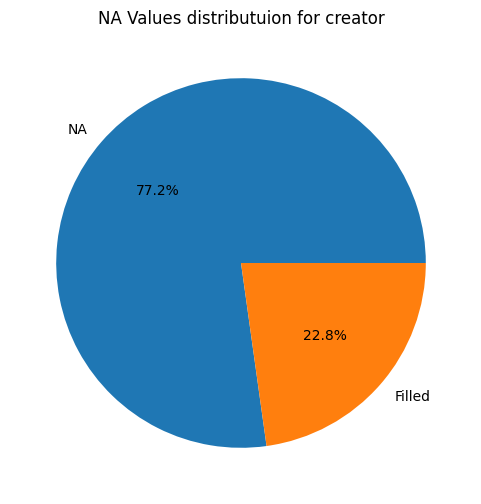

In [229]:
freqency_table = getFrequencyTable(cat, "creator")
display(freqency_table)

# Review unique values
unique_vals =list(cat["creator"].unique())
print(f"Categories contains {len(unique_vals)} unique values")

# What is the distribution of NaN values
print("\nNA Values distributuion")
plt.figure(figsize=(6,6))
plt.pie(cat["creator"].isna().value_counts(), autopct='%1.1f%%', labels=["NA", "Filled"])
plt.title(f"NA Values distributuion for creator")
plt.show();

**Analysis**
- Only the 23% of the articles has the creator defined. This might be caused due a problem with different sources xml schema and the import process.
- Extra cleaning could be helful in case the creator is important for the task (not in this case) since some of the fields contain more than one creator separated with "," or "and".
- 3% of the articles are written by TechCrunch Events

##### Categories

,count,proportion
categories,,
"Business, Artificial Intelligence",9,0.02
Politics,6,0.01
"Gear News and Events, Gear",6,0.01
"Gear, Gear News and Events",6,0.01
Gear,5,0.01
...,...,...
"Products, Trends, Lifestyle, How To and Advice, Gear",1,0.00
"Policy, Canada, tariffs, Donald Trump, digital services tax, DST",1,0.00
"budget cuts, Science, Trump, NIH, Health, syndication",1,0.00


Categories contains 373 unique values

NA Values distributuion


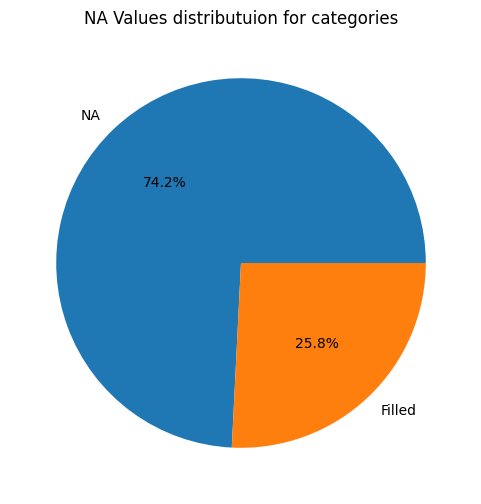

In [230]:
# Initial Reiew
freqency_table = getFrequencyTable(cat, "categories")
display(freqency_table)

# Review unique values
unique_vals =list(cat["categories"].unique())
print(f"Categories contains {len(unique_vals)} unique values")

# What is the distribution of NaN values
print("\nNA Values distributuion")
plt.figure(figsize=(6,6))
plt.pie(cat["categories"].isna().value_counts(), autopct='%1.1f%%', labels=["NA", "Filled"])
plt.title(f"NA Values distributuion for categories")
plt.show();

Categories contains 1217 unique values:

Categories Distribution:


,count,proportion
category,,
Gear,87,0.03
Products,58,0.02
Buying Guides,41,0.01
Trump,36,0.01
Donald J,34,0.01
...,...,...
J D,1,0.00
Riedel,1,0.00
Bruce O,1,0.00


Show top 50 Categories


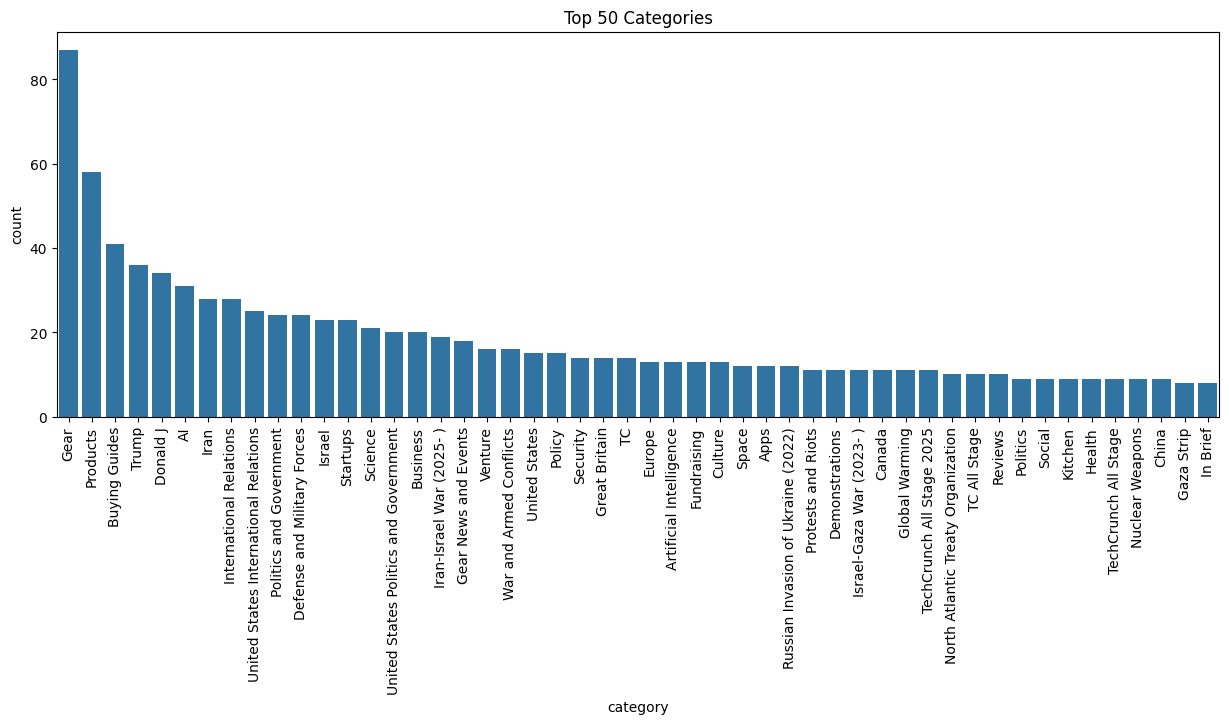

In [231]:
# Find Unique Categories
categories = []
for creator in cat.loc[cat["categories"].isna() == False, "categories"]:
    categories += creator.split(", ")

individual_cat = pd.DataFrame(categories, columns=["category"])

# Review unique values
unique_vals =list(individual_cat["category"].unique())
print(f"Categories contains {len(unique_vals)} unique values:")


# Showing Frequency for the unique categories
print(f"\nCategories Distribution:")
freqency_table = getFrequencyTable(individual_cat, "category")
display(freqency_table)

plt.figure(figsize=(15,5))
show_top = 50
print(f"Show top {show_top} Categories")
ax = sns.barplot(x=freqency_table[:show_top].index, y=freqency_table[:show_top]["count"], data=freqency_table[:show_top], legend=True)
plt.xticks(rotation=90)
plt.title(f"Top {show_top} Categories")
plt.show();


**Analysis**
- 74% of the articles has no categories set, this might be an issue based on how different sources implement the XML tags and the import settings.
- An initial analysis of the categories showed 373 different categories but as many of these categories where a collection of categories splitted with a coma, I decided to do the split and analyze them independently.
- The Analysis after the split showed 1217 unique categories. A deeper clean could improve this since there are resulting categories that are a full sentence.
- The most frequent category is Geat with a 3% of the articles (87/566).

##### media_url

In [293]:
cat["media_url"].isna().value_counts()

media_url
True     355
False    211
Name: count, dtype: int64

,count,proportion
media_url,,
https://static01.nyt.com/images/2025/07/02/multimedia/02int-dalai-lama-succession-pwhb/02int-dalai-lama-succession-pwhb-mediumSquareAt3X.jpg,1,0.0
https://static01.nyt.com/images/2025/07/01/multimedia/00int-dalai-lama-top-tfkl/00int-dalai-lama-top-tfkl-mediumSquareAt3X.jpg,1,0.0
https://static01.nyt.com/images/2025/07/01/multimedia/02ambriefing-europe-nl-dc-congress/02ambriefing-europe-nl-dc-congress-mediumSquareAt3X.jpg,1,0.0
https://static01.nyt.com/images/2025/07/01/multimedia/01cli-trash-trade-war-fgqm/01cli-trash-trade-war-fgqm-mediumSquareAt3X.jpg,1,0.0
https://static01.nyt.com/images/2025/07/01/multimedia/01uk-letby-qwbt/01uk-letby-qwbt-mediumSquareAt3X.jpg,1,0.0
...,...,...
https://static01.nyt.com/images/2025/06/24/multimedia/24iran-israel-Pezeshkian-zlmt/24iran-israel-Pezeshkian-zlmt-mediumSquareAt3X.jpg,1,0.0
https://static01.nyt.com/images/2025/06/25/multimedia/25ambriefing-asia-nl-lede-tjmh/25ambriefing-asia-nl-lede-tjmh-mediumSquareAt3X.jpg,1,0.0
https://static01.nyt.com/images/2025/06/24/multimedia/24int-canada-heat-gfpj/24int-canada-heat-gfpj-mediumSquareAt3X.jpg,1,0.0


media_url contain 212 unique values

NA Values distributuion


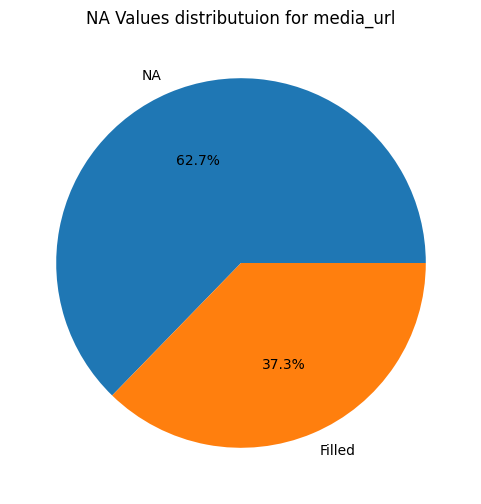

In [233]:
# Initial Reiew
freqency_table = getFrequencyTable(cat, "media_url")
display(freqency_table)

# Review unique values
unique_vals =list(cat["media_url"].unique())
print(f"media_url contain {len(unique_vals)} unique values")

# What is the distribution of NaN values
print("\nNA Values distributuion")
plt.figure(figsize=(6,6))
plt.pie(cat["media_url"].isna().value_counts(), autopct='%1.1f%%', labels=["NA", "Filled"])
plt.title(f"NA Values distributuion for media_url")
plt.show();

**Analysis**
- Media url is not a categorical variable since every article have a unique image. This was expected but I wanted to validate if any article shared the image.
- The NA distribution shows that majortiy of the data has no media_url. This might be a sympthom of a wrong import in data (sources using different xml tags for this info)

##### media_medium

,count,proportion
media_medium,,
image,211,1.0


media_medium contain 2 unique values

NA Values distributuion


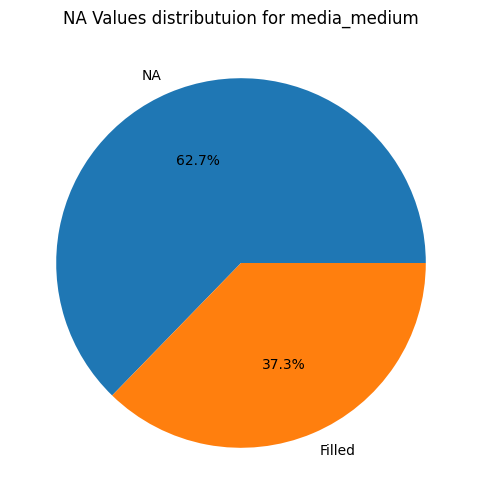

In [234]:
# Initial Reiew
freqency_table = getFrequencyTable(cat, "media_medium")
display(freqency_table)

# Review unique values
unique_vals =list(cat["media_medium"].unique())
print(f"media_medium contain {len(unique_vals)} unique values")

# What is the distribution of NaN values
print("\nNA Values distributuion")
plt.figure(figsize=(6,6))
plt.pie(cat["media_medium"].isna().value_counts(), autopct='%1.1f%%', labels=["NA", "Filled"])
plt.title(f"NA Values distributuion for media_medium")
plt.show();

**Analysis**:
- There are only 2 values in the database for media_medium ("image" or NULL)
- The is the same amout of articles having set this value than media_url (211), its safe to assume they are the same articles.
- As expected in the previous point NA distribution is showing the same results confirming there could be an issue in the import of different sources.
- A later bivariate analysis comparing the num of empty values per source could help to validate the previous asumption.

##### media_credit

,count,proportion
media_credit,,
Arash Khamooshi for The New York Times,13,0.06
Haiyun Jiang/The New York Times,10,0.05
Eric Lee/The New York Times,3,0.01
Getty Images,3,0.01
The New York Times,3,0.01
...,...,...
Amir Cohen/Reuters,1,0.00
Bianca De Marchi/Australian Associated Press,1,0.00
Matthew Abbott for The New York Times,1,0.00


media_credit contain 157 unique values

NA Values distributuion


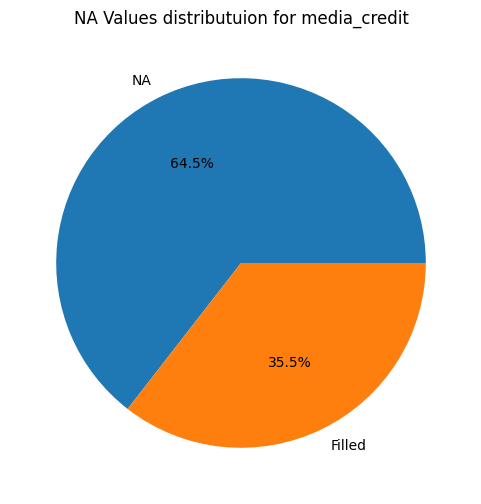

In [294]:
# Initial Reiew
freqency_table = getFrequencyTable(cat, "media_credit")
display(freqency_table)

# Review unique values
unique_vals =list(cat["media_credit"].unique())
print(f"media_credit contain {len(unique_vals)} unique values")

# What is the distribution of NaN values
print("\nNA Values distributuion")
plt.figure(figsize=(6,6))
plt.pie(cat["media_credit"].isna().value_counts(), autopct='%1.1f%%', labels=["NA", "Filled"])
plt.title(f"NA Values distributuion for media_credit")
plt.show();

**Analysis**
- Data might require further cleaning since some of the media_credit is having ",", "for", or "/" indicating that might be more than one person or entity recognize in the articles.
- Even with there is a common media credit for the 6% of the articles.
- Again the NA distribution shows that almos 2/3 of the articles has no media_credits. 
- Looking at the data seems that only "The New York Times" is setting this field but it could be related to the XML import and different XML schemas.

##### id_source

,count,proportion
id_source,,
1.0,178,0.31
2.0,137,0.24
4.0,128,0.23
6.0,74,0.13
7.0,49,0.09


id_source contain 5 unique values


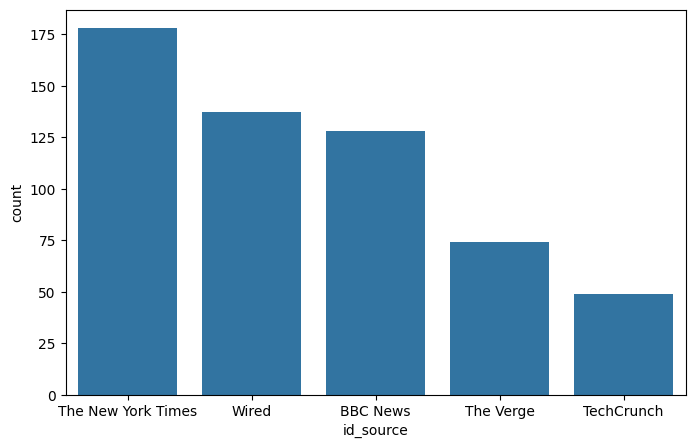

In [285]:
# Initial Reiew
freqency_table = getFrequencyTable(cat, "id_source")
display(freqency_table)

# Review unique values
unique_vals =list(cat["id_source"].unique())
print(f"id_source contain {len(unique_vals)} unique values")

plt.figure(figsize=(8,5))
ax = sns.barplot(x=freqency_table.index, y=freqency_table["count"], data=freqency_table, legend=True)
ax.xaxis.set_major_locator(mticker.FixedLocator(database_sources_df.index))
ax.set_xticklabels(database_sources_df["title"])
plt.show();


**Analysis:**
- The New York times is the source with more articles (31%) and TechCrunch the one with less (9%)
- There are currently only 5 sources

#### Continuous

In [286]:
num

,media_height,in_vectorstore,title_length,title_words,desc_length,desc_words,mdesc_length,mdesc_words
0,0.0,1.0,45,8,164,30,0,0
1,0.0,1.0,57,9,123,20,0,0
2,0.0,1.0,79,14,138,23,187,31
3,0.0,1.0,68,11,81,16,0,0
4,0.0,1.0,66,10,107,16,0,0
...,...,...,...,...,...,...,...,...
561,0.0,1.0,73,12,193,29,0,0
562,0.0,1.0,47,8,196,33,0,0
563,0.0,1.0,25,5,79,14,0,0
564,0.0,1.0,53,10,88,14,0,0


In [287]:
describe_complete(num)

,count,unique,mean,min,quant_25,quant_50,quant_75,max,mode,var,std,skew,kurt
media_height,566,1,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000
in_vectorstore,566,1,1.000000,1.0,1.0,1.0,1.00,1.0,1.0,0.000000,0.000000,0.000000,0.000000
title_length,566,83,62.738516,11.0,53.0,62.0,72.00,131.0,57|60,246.699647,15.706675,0.001863,1.270463
title_words,566,18,10.330389,2.0,9.0,10.0,12.00,22.0,10,7.202155,2.683683,0.050480,1.243579
desc_length,566,170,136.409894,0.0,106.0,128.0,160.00,433.0,119|126|138,2894.245849,53.798196,1.686554,6.306053
desc_words,566,44,21.720848,0.0,16.0,21.0,26.00,56.0,16,81.585653,9.032478,1.279436,3.556898
mdesc_length,566,106,31.549470,0.0,0.0,0.0,45.75,297.0,0,3507.748876,59.226252,1.796484,2.384895
mdesc_words,566,36,5.153710,0.0,0.0,0.0,8.00,49.0,0,93.125004,9.650130,1.773500,2.234065


**Analysis**:
- All the values in **media_height** are 0 this could be due an error in the import process.
- All values in **in_vectorstore** are 1 this acts as an internal boolean for the application.

The text length and number of words can give an indea on the amount of tokens and space needed to process and store the informaion (insightfull in order to decide how much information I can send to the model based on its context size and token cost)
- There **title** from 11 to 131 characters, being around 60 the most frequent ones. 
- **Title** number of words go from 2 to 22 being 10 the most common. 
- **Description** has a length in between 0 and 433 characters that represent a maximum of 56 words. 126 characters and 16 words seems the most common.
- **Media Description** can have until 297 characters in 49 words.

### Bivariate Analysis

#### Number of post per day and source

source,Ars Technica,BBC News,TechCrunch,The New York Times,Wired
pub_date,,,,,
2025-04-30,0,1,0,0,0
2025-06-08,0,1,0,0,0
2025-06-22,0,0,0,0,3
2025-06-23,0,0,0,0,12
2025-06-24,0,0,0,7,16
2025-06-25,0,1,0,34,18
2025-06-26,5,0,0,26,14
2025-06-27,11,1,10,20,20
2025-06-28,2,0,6,17,14


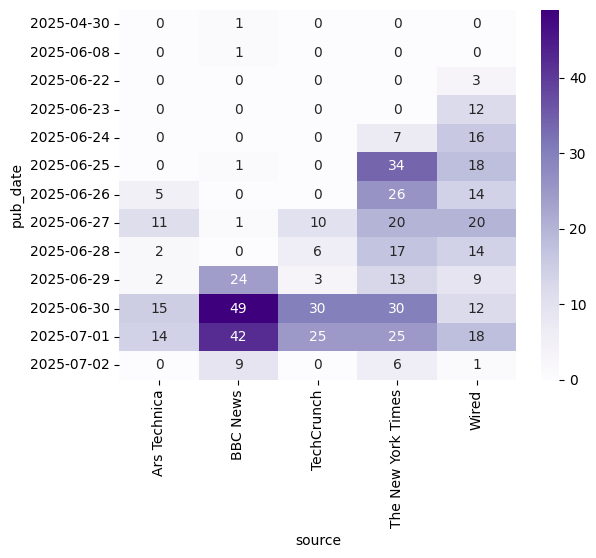

In [326]:
tmp_df = clean_articles_df[["id", "id_source", "pub_date"]].copy()
tmp_df["source"] = tmp_df["id_source"].apply(lambda x: database_sources_df.loc[database_sources_df["id"] == x, "title"].values[0])
tmp_df.drop("id_source", axis=1, inplace=True)

tmp_df["pub_date"] = tmp_df["pub_date"].dt.to_period('D')

# CrossTab
crosstab_result = pd.crosstab(tmp_df["pub_date"], tmp_df["source"])
display(crosstab_result)

## Frequency Heat Maps
sns.heatmap(crosstab_result, annot=True, cmap="Purples", fmt="d");

**Analysis**
- While there are a lot of days in the source see empty values doesn't mean there was not publications but that the RSS did not provide them.
- For reference, the project was started on 25/06 with just "New Yourk Times" as Source. The other sources were added on 30/06.


I would need to have more data to take deeper conclusions but focusing on the days 30/06 and 01/07 (on  02/07 data was freeze):
- BBC News publish around 45 articles per day, Tech Crunh and TNYT 27.5  and arond 15 Wired and Ars Technica
- The previous makes around 130 articles per day just with 5 sources

### EDA Conclusion
- Its needed to improve the RSS import since many sources has empty fields due to errors in the parser or different XML implementations
- It's relevant to be able to sort articles through category since there are mored than 1200 categories in for 5 sources in 13 (incomplete) days of information.
- It's also relevant to use an application to group and condense the information from different sources since 130 articles a day might be difficult to follow.

In [329]:
# Just to leave the environment as it was before
!pip uninstall -y matplotlib seaborn

Found existing installation: matplotlib 3.10.3
Uninstalling matplotlib-3.10.3:
  Successfully uninstalled matplotlib-3.10.3
Found existing installation: seaborn 0.13.2
Uninstalling seaborn-0.13.2:
  Successfully uninstalled seaborn-0.13.2
